Here we study how number of pairs change with the sky area of lenses.

In [1]:
# Standard imports
import copy
import corner
import numpy as np
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
from itertools import combinations
from IPython.display import display, Markdown, Math
from mpl_toolkits.axes_grid1 import make_axes_locatable


# Astropy imports
from astropy.io import fits
from astropy import units as u
from astropy.table import Table
from astropy.units import Quantity
from astropy import constants as const

# SLSim imports
import slsim.Pipelines as pipelines
import slsim.Sources as sources
import slsim.Deflectors as deflectors
from slsim.Lenses.lens_pop import LensPop
from slsim.Plots.lens_plots import LensingPlots
from slsim.Lenses.lens import Lens
from slsim.LOS.los_pop import LOSPop

# Lenstronomy, HierArc imports
from lenstronomy.LensModel.lens_model import LensModel
from hierarc.Sampling.ParamManager.cosmo_param import CosmoParam

from utils import generate_fake_catalog, run_pairing_simulation_from_data, run_pairing_simulation, fit_plane, find_scatter

/Users/paras/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/paras/Projects/repos/self/slsim/slsim/Plots/lens_plots.py:5: UserWarning: If you want to simulate images with Roman filters, please install the galsim module.
Note that this module is not supported on Windows
  from slsim.ImageSimulation.roman_image_simulation import simulate_roman_image


In [5]:
# load the GGL data tables with different sky areas of lenses bu galaxy population is on 10 deg^2
sky_area = "50.0v2"
GGL_data_table = Table.read(f"../data/GGL_{sky_area}_SQDEG_RED_DEFLECTOR_BLUE_SOURCE.fits", format='fits')
GGL_data_table

lens_id,z_D,z_S,theta_E,sigma_v_D,stellar_mass_D,mag_S_i,mag_S_r,mag_S_g,mag_S_z,mag_S_y,mag_D_i,mag_D_r,mag_D_g,mag_D_z,mag_D_y,size_D,e1_mass_D,e2_mass_D,e_mass_D,gamma_pl,R_e_kpc,Sigma_half_Msun/pc2,surf_bri_mag/arcsec2
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64
0,1.1395730540197462,2.721757883923871,0.6383209474735921,234.52827079090258,408649665972.69635,25.933963738373834,26.127290551620234,26.254675998006924,25.877372770610663,25.77967242684352,22.98925557393261,24.057250718125182,25.178428704908463,22.13937039113474,21.469667400192904,0.5236284022464591,-0.2185177432823041,0.0403576488557333,0.22221328481968317,2,4.30707590221643,6033.914441400326,26.23568913352215
1,1.1676192009673254,2.838231941243875,0.5428598143754139,215.84729996869848,324309245490.47504,24.22762289989987,24.307252461915994,24.330966194829777,24.19614120355442,24.25840995562706,23.4402925996813,24.481996698219838,25.35590571629431,22.647451548717875,21.931126586377424,0.2833098895986966,0.01249637671998382,-0.11601750873715334,0.11668856741216427,2,2.339785570397245,9636.754519164577,25.086016539203026
2,0.8496635018062778,3.3535717429740073,0.641000768077548,198.8149905902349,252718868917.48575,25.559769535693853,25.692328159661358,26.0026527226674,25.435595481739007,25.34701222772341,21.96306329205506,22.827566278001065,23.54640956678392,21.2303460229086,20.962437814004915,0.23774477841756192,0.0316484729535937,0.16867423476209303,0.17161766608619294,2,1.820585794159507,9782.545548619119,22.86143073655398
3,1.5030247928909466,2.1037429248665225,0.5111993143704567,314.13299407421005,883777743495.4609,26.510924542753955,26.70858277146902,27.1583892110041,26.131180343134147,25.81278128068294,23.77862974498593,25.346268769963384,26.00807169213301,22.905058039418602,22.357811050847626,1.4659095665465913,-0.009356050373493305,-0.025632148189255435,0.027286309742933265,2,12.406290085901004,3755.908492949182,29.310824741747
4,0.09931798255962809,2.1700020122674757,0.8909096122755212,182.91937545558415,192914100798.88678,26.068800062516363,26.18260302373776,26.453438870162888,25.85431274554333,25.597538901622872,15.682406808159396,16.184348056972592,17.024734167739563,15.371562734687448,15.1519986272104,1.8882089102964354,-0.03149400430312179,0.020689174501004406,0.03768174954242524,2,3.4613724155333387,993.0878825186128,20.86717108100093
5,0.5288078808555957,4.343158907234654,1.8475198758908336,295.8237930636839,760108618473.295,26.489822086076952,26.713722342261637,27.968750435273822,26.51430656934446,26.36029223477607,18.820681063983304,19.673589738103377,20.940708005983755,18.453013637031862,18.219862227367084,1.3974704615046138,-0.037506289136146086,0.029683186537268865,0.04783109122496046,2,8.783981475448723,4329.28295528526,24.12990678858026
6,1.4559015868937206,3.8947692755843875,0.6865247003713678,244.97777562316497,462966940487.00793,26.6810933315858,26.722212903637512,27.36112014871479,26.47404290286856,26.398807903193074,24.046814542508628,25.29251052208788,25.617233245782813,23.347386960561984,22.7428989776878,0.3386182857665169,-0.03450844210644334,-0.04499833975555973,0.056706993901727315,2,2.862031469438829,11700.201951750312,25.745941106562977
7,0.2806689195320025,1.7410928677555793,0.702790233640981,178.45741656564877,176660221028.014,26.85810971732381,27.019893227146323,27.191141500680875,26.537720058873933,26.28112734684412,18.536060330766365,19.020192408396266,20.210660912850745,18.275044840954653,18.081439214360305,0.5836787330604735,-0.10351118102632655,-0.293874446056699,0.31157142783412706,2,2.481363853666704,2908.161559314505,21.745803937276175
8,0.7706303273274793,4.211551756362357,0.9218938814173087,225.27783876034175,365843003536.67883,26.207415223007033,26.463795844134502,27.56823350434354,26.10852487865217,25.982309600016222,21.08702338199977,22.261540879019485,23.52052383691099,20

In [6]:
# fit the MFP
coeffs_MFP = fit_plane(
    np.log10(GGL_data_table["R_e_kpc"]),
    np.log10(GGL_data_table["Sigma_half_Msun/pc2"]),
    np.log10(GGL_data_table["sigma_v_D"])
)

# find the scatter
scatter_MFP = find_scatter(
    np.log10(GGL_data_table["R_e_kpc"]),
    np.log10(GGL_data_table["Sigma_half_Msun/pc2"]),
    np.log10(GGL_data_table["sigma_v_D"]),
    coeffs_MFP,
    return_fit=False
)

coeffs_MFP_alt = fit_plane(
    np.log10(GGL_data_table["sigma_v_D"]),
    np.log10(GGL_data_table["Sigma_half_Msun/pc2"]),
    np.log10(GGL_data_table["R_e_kpc"]),
)

scatter_MFP_alt = find_scatter(
    np.log10(GGL_data_table["sigma_v_D"]),
    np.log10(GGL_data_table["Sigma_half_Msun/pc2"]),
    np.log10(GGL_data_table["R_e_kpc"]),
    coeffs_MFP_alt,
    return_fit=False
)

display(Markdown(f"SLSim MFP: "+"$\\log_{10}(\\sigma_v)$ = " + f"{coeffs_MFP[0]:.2f} * "+"$\\log_{10}(R_e)$"+f" + {coeffs_MFP[1]:.2f} * "+"$\\log_{10}(\\Sigma_{1/2}) + "+f"{coeffs_MFP[2]:.2f}$ " + "$\\Rightarrow \\Delta \\log_{10}(\\sigma_v)$ = " + f"{np.std(scatter_MFP):.2f} dex "+"$\\Rightarrow {\\Delta \\sigma_v}/{\\sigma_v}$: " + f"{np.std(scatter_MFP)*np.log(10)*100:.2f} %"))
display(Markdown(f"SLSim MFP (alt): "+"$\\log_{10}(R_e)$ = " + f"{coeffs_MFP_alt[0]:.2f} * "+"$\\log_{10}(\\sigma_v)$"+f" + {coeffs_MFP_alt[1]:.2f} * "+"$\\log_{10}(\\Sigma_{1/2}) + "+f"{coeffs_MFP_alt[2]:.2f}$ " + "$\\Rightarrow \\Delta \\log_{10}(R_e)$ = " + f"{np.std(scatter_MFP_alt):.2f} dex "+"$\\Rightarrow {\\Delta R_e}/{R_e}$: " + f"{np.std(scatter_MFP_alt)*np.log(10)*100:.2f} %"))

SLSim MFP: $\log_{10}(\sigma_v)$ = 0.37 * $\log_{10}(R_e)$ + 0.24 * $\log_{10}(\Sigma_{1/2}) + 1.23$ $\Rightarrow \Delta \log_{10}(\sigma_v)$ = 0.04 dex $\Rightarrow {\Delta \sigma_v}/{\sigma_v}$: 8.41 %

SLSim MFP (alt): $\log_{10}(R_e)$ = 2.21 * $\log_{10}(\sigma_v)$ + -0.51 * $\log_{10}(\Sigma_{1/2}) + -2.68$ $\Rightarrow \Delta \log_{10}(R_e)$ = 0.09 dex $\Rightarrow {\Delta R_e}/{R_e}$: 20.39 %

Number of pairs in the original data: 3925
Number of pairs in the fake data: 5359


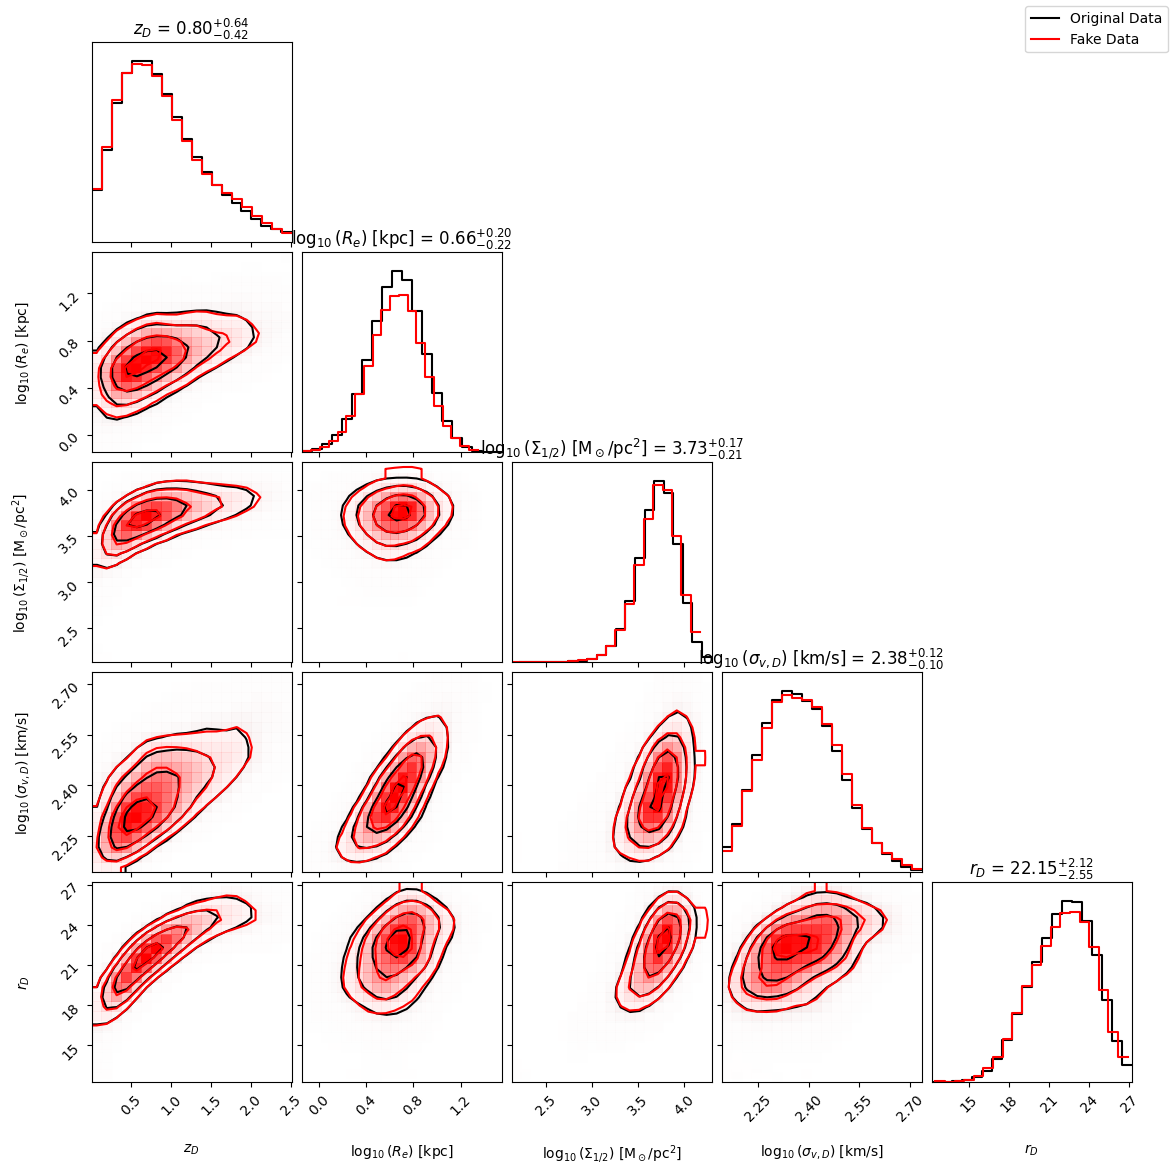

In [7]:
#### SANITY CHECK with the original data

fake_data_org = generate_fake_catalog(
    source_table=GGL_data_table,
    num_samples=len(GGL_data_table),
)

print("Number of pairs in the original data:", run_pairing_simulation_from_data(
    data=GGL_data_table,
    mag_limit=28,
    threshold_rel_delta_z=0.01,
    verbose=False
))
print("Number of pairs in the fake data:", run_pairing_simulation_from_data(
    data=fake_data_org,
    mag_limit=28,
    threshold_rel_delta_z=0.01,
    verbose=False
))


### corner plot of the fake data vs the original data

data_corner = np.array([
    GGL_data_table['z_D'],
    np.log10(GGL_data_table["R_e_kpc"]),
    np.log10(GGL_data_table["Sigma_half_Msun/pc2"]),
    np.log10(GGL_data_table["sigma_v_D"]),
    GGL_data_table['mag_D_r']
]).T   

fig_corner = corner.corner(
    data_corner,
    labels=[r'$z_D$', r'$\log_{10}(R_e)$ [kpc]', r'$\log_{10}(\Sigma_{1/2})$ [M$_\odot$/pc$^2$]', r'$\log_{10}(\sigma_{v, D})$ [km/s]', r'$r_D$'],
    show_titles=True,
    smooth=True,
    smooth1d=True,
    plot_datapoints=False,
);

data_corner_fake = np.array([
    fake_data_org['z_D'],
    np.log10(fake_data_org["R_e_kpc"]),
    np.log10(fake_data_org["Sigma_half_Msun/pc2"]),
    np.log10(fake_data_org["sigma_v_D"]),
    fake_data_org['mag_D_r']
]).T

corner.corner(
    data_corner_fake,
    labels=[r'$z_D$', r'$\log_{10}(R_e)$ [kpc]', r'$\log_{10}(\Sigma_{1/2})$ [M$_\odot$/pc$^2$]', r'$\log_{10}(\sigma_{v, D})$ [km/s]', r'$r_D$'],
    show_titles=True,
    smooth=True,
    smooth1d=True,
    fig=fig_corner,
    color= 'red',
    plot_datapoints=False,
    
);

fig_corner.legend(['Original Data', 'Fake Data'])

In [8]:
fake_data_org

z_D,z_S,theta_E,sigma_v_D,stellar_mass_D,mag_S_i,mag_S_r,mag_S_g,mag_S_z,mag_S_y,mag_D_i,mag_D_r,mag_D_g,mag_D_z,mag_D_y,size_D,e1_mass_D,e2_mass_D,e_mass_D,gamma_pl,R_e_kpc,Sigma_half_Msun/pc2,surf_bri_mag/arcsec2
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64
0.2760652195087788,2.427354468118864,0.7957381118208279,185.57048975031248,199558440163.37915,27.12424791289193,27.348677706967017,27.58776252913879,27.00123718966523,26.770564292980005,18.319311684558134,18.857590182774633,20.027025711277442,17.998901985420733,17.768087258658003,0.9255621980272452,0.060143253930501975,-0.017776117851878458,0.06091368095537699,2,3.873559423967171,2089.3509459214615,22.352052529428924
0.5502137291772747,3.4177367483416137,1.4645426746569143,271.0776905489191,588629864050.4453,27.208755089556174,27.256420862531314,27.563446273868173,27.183223208249686,27.080414826271895,19.22716405723212,20.12517082377204,21.462191759581014,18.831087334687513,18.571519966587697,0.8573063101332646,-0.06069226591416988,-0.06395274400485074,0.09012534708930199,2,5.514105242068368,5323.718418967577,23.589493369524405
1.035808078299169,3.5331256503520034,0.5715215204476248,198.62103664804448,252026641786.05032,26.615990929733755,26.661483855445056,27.169062382147786,26.44990549809195,26.321958011029345,22.63830327042967,23.230743415652324,23.65778912106502,21.928865691332884,21.467331740982118,0.4579766371191253,0.004154813351682469,-0.009466601677843162,0.011578227234706024,2,3.724653325021813,5367.883981023094,24.391809098893646
1.4531423286511969,3.3177927468027075,0.936510993710125,302.54304514935205,807450198110.6217,26.986221271711862,27.084663210063628,27.356693779013042,26.902930393545585,26.8083253528458,23.342479998677607,24.441720335861252,24.74788614471746,22.70156488911554,22.07108474369309,0.9240778291273375,0.08042310665339748,0.11478215148642257,0.13939865994951742,2,7.723391169586866,6246.118793049441,26.995072515650033
0.34753277624378554,4.413638051507652,1.5968256273770802,259.9273388191911,538228121510.1569,26.190292990530633,26.54421545415511,27.97288651428844,26.203161129888997,25.99304047419797,17.877798585896695,18.407266810806615,19.786280417978475,17.555946420601572,17.373565231971906,1.3808358676169956,-0.12832548586784867,0.11581263142225884,0.17341432817596708,2,6.790528234253934,3431.669603995589,22.947226943833172
0.4350048918492557,2.7470988894230097,1.0376408109059307,224.08088506585935,352227703759.34924,26.187023754290813,26.331356721488447,26.442115474212844,26.098093752993456,26.023856820416555,19.097938136874326,19.755836904071963,21.2499601764282,18.649956088128505,18.51519257897452,0.8916850167930909,0.11408773021522853,0.024299849985449908,0.11524611574707488,2,5.040705407424,3252.798782038848,23.46791990696203
0.8741876221258688,3.45738621254654,1.4273441623219518,297.85325832051865,788399713135.5875,26.622543576542952,26.609890280166262,26.994716157060054,26.558269275275617,26.475525099831124,21.023238183374,22.019326501241885,23.094715821130812,20.218088875441964,19.898853499748455,0.7646631199272461,-0.02617974152426743,-0.12173442077359471,0.1234242661447112,2,5.871557962915228,7320.705244016865,24.97786163803657
0.7099698204078829,3.050302882366874,1.3365528136844043,275.63062746040055,622219145883.4343,26.517158015078394,26.63105472071,26.737301774582402,26.416494072529222,26.455639716276277,19.95663161522811,21.095994275764006,22.452350315464216,19.495560178101176,19.25452759186467,0.7915591506837739,-0.01772866151479081,-0.04343386698091022,0.04550301099428871,2,5.683461409371115,5724.127568352704,24.425072793994083
0.21687807239596693,1.904302029249055,0.6367791281097244,163.70841568786537,139114549309.6685,24.49326858961727,24.660269244862338,24.937063259946722,24.160948692801863,23.96380601542968,18.23401111843949,18.71639383322313,19.68072209522832,18.02205585239971,17.8229

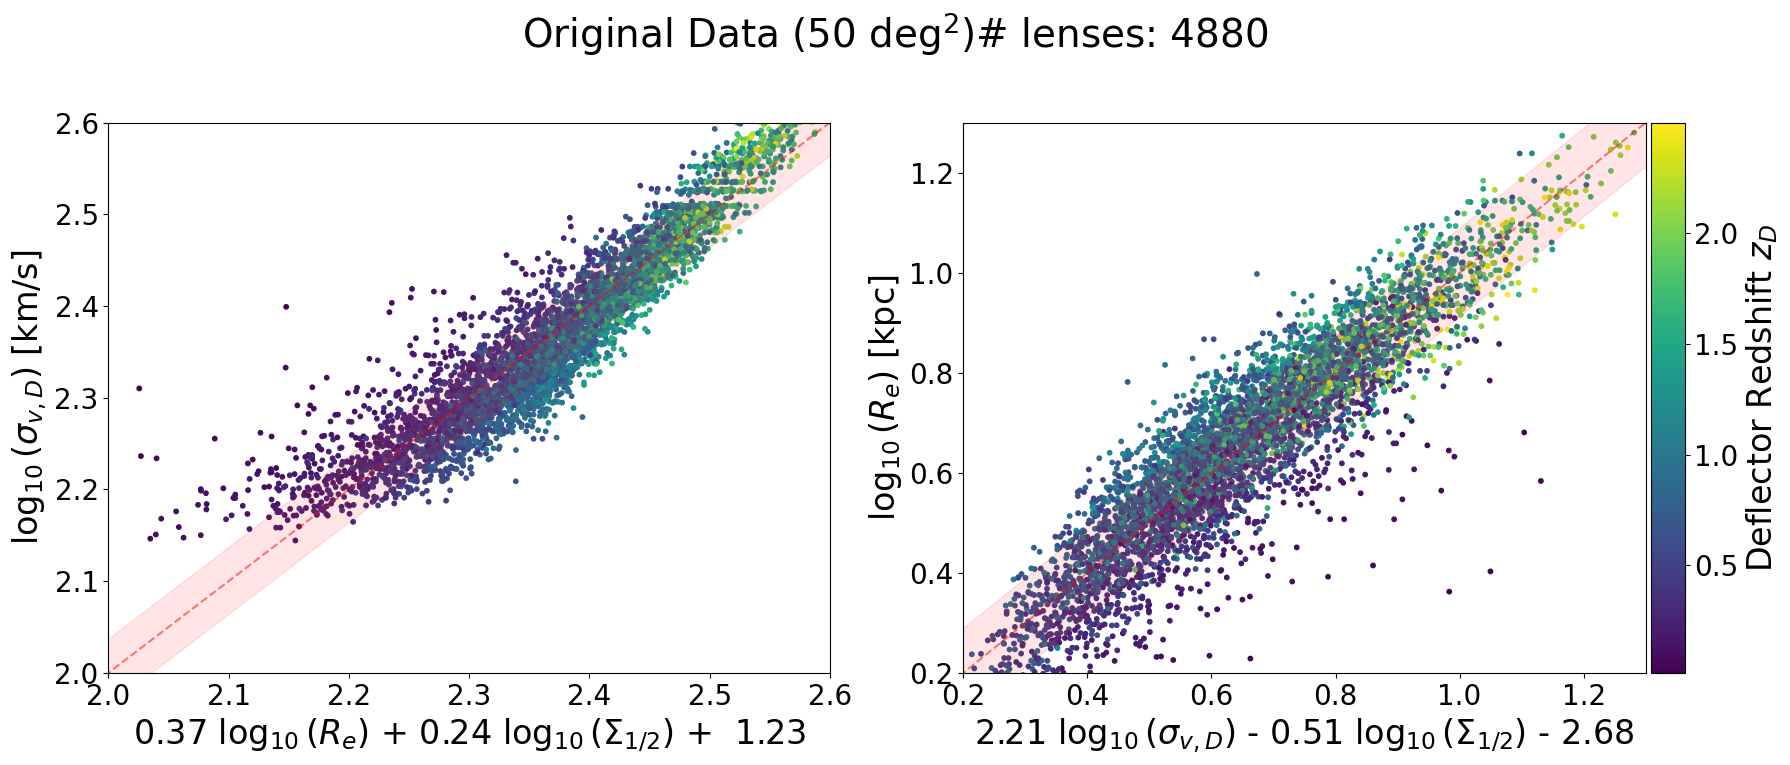

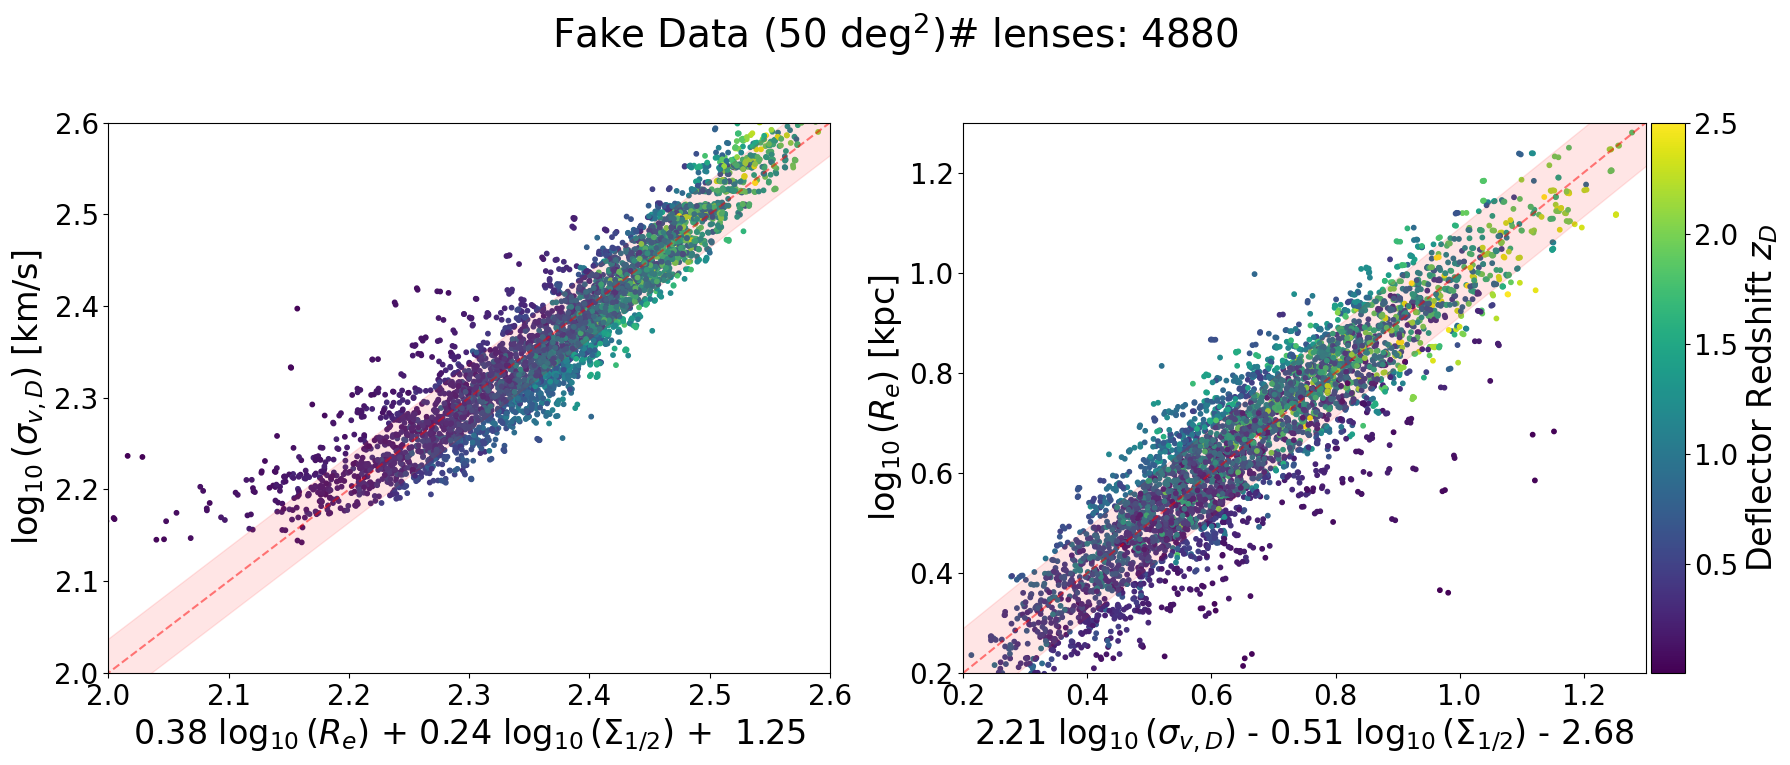

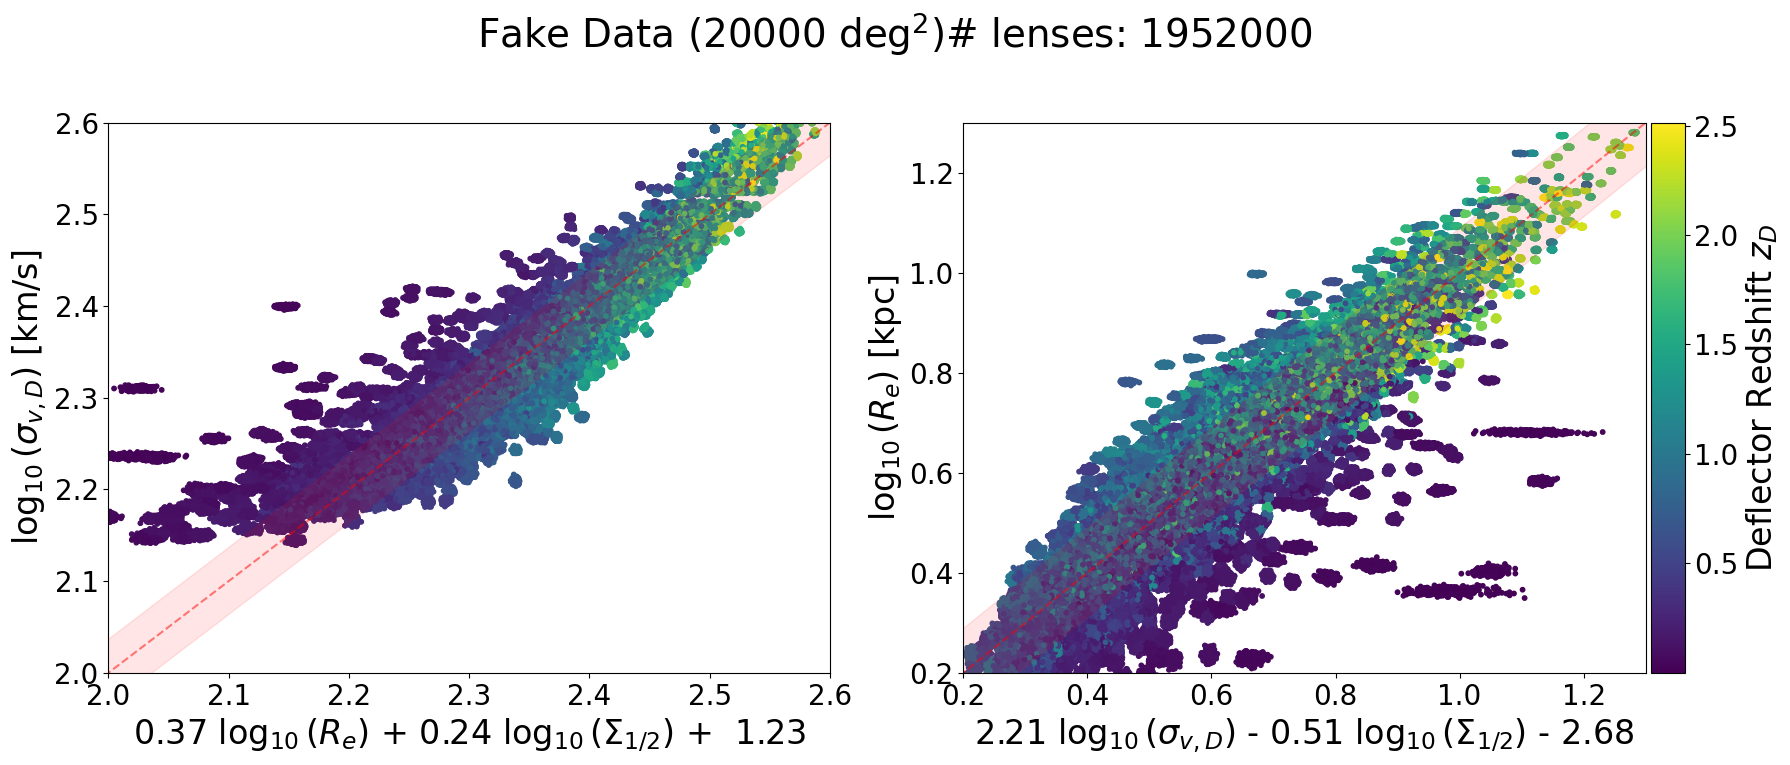

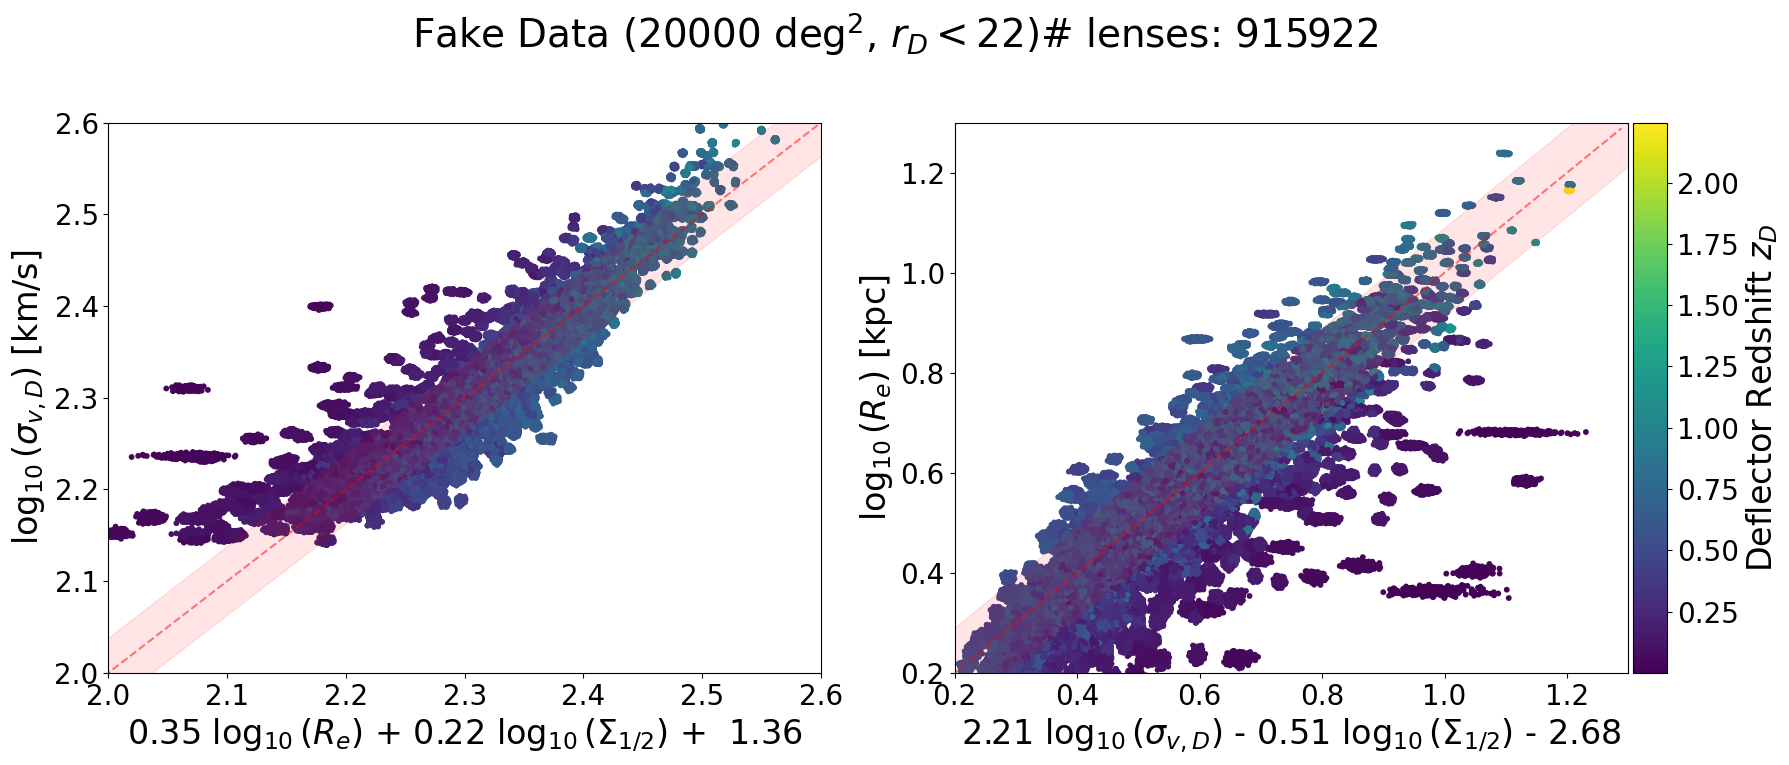

In [9]:
# MFP for the original data and the fake data

larger_area_fake_data = generate_fake_catalog(
    source_table=GGL_data_table,
    num_samples= int(20000/50 * len(GGL_data_table)),  # 20000 deg^2
)

larger_area_fake_data_bright = larger_area_fake_data[larger_area_fake_data['mag_D_r'] < 22]

title_list = [
    "Original Data (50 deg$^2$)" + f"# lenses: {len(GGL_data_table)}",
    "Fake Data (50 deg$^2$)" + f"# lenses: {len(fake_data_org)}",
    "Fake Data (20000 deg$^2$)" + f"# lenses: {len(larger_area_fake_data)}",
    "Fake Data (20000 deg$^2$, $r_D < 22$)" + f"# lenses: {len(larger_area_fake_data_bright)}"
]
i = 0
for data_table in [GGL_data_table, fake_data_org, larger_area_fake_data, larger_area_fake_data_bright]:
    # fit the MFP
    coeffs_MFP = fit_plane(
        np.log10(data_table["R_e_kpc"]),
        np.log10(data_table["Sigma_half_Msun/pc2"]),
        np.log10(data_table["sigma_v_D"])
    )

    # find the scatter
    scatter_MFP = find_scatter(
        np.log10(data_table["R_e_kpc"]),
        np.log10(data_table["Sigma_half_Msun/pc2"]),
        np.log10(data_table["sigma_v_D"]),
        coeffs_MFP,
        return_fit=False
    )

    # side-by-side plot of the two fundamental planes
    fig, axs = plt.subplots(1, 2, figsize=(18, 8))

    # sigma_v fundamental plane
    axs[0].scatter(
        coeffs_MFP[0] * np.log10(data_table["R_e_kpc"]) + 
        coeffs_MFP[1] * np.log10(data_table["Sigma_half_Msun/pc2"]) + 
        coeffs_MFP[2],
        np.log10(data_table["sigma_v_D"]),
        c=data_table["z_D"], s=10, label='SLSim MFP', 
        cmap='viridis'
    )
    axs[0].set_xlabel(f'{coeffs_MFP[0]:.2f} ' + r'$\log_{10}(R_e)$ + ' + f'{coeffs_MFP[1]:.2f} ' + r'$\log_{10}(\Sigma_{1/2})$ + ' + f' {coeffs_MFP[2]:.2f}')
    axs[0].set_ylabel(r'$\log_{10}(\sigma_{v, D})$ [km/s]')
    # axs[0].set_title('SLSim Mass Fundamental Plane', fontsize=16)

    # Plot the fitted plane with a faded scatter
    # y = x
    axs[0].plot([axs[0].get_xlim()[0], axs[0].get_xlim()[1]],
                [axs[0].get_xlim()[0], axs[0].get_xlim()[1]],
                color='red', linestyle='--', alpha=0.5, label='y = x')
    # faded region for the scatter
    x_faded = np.linspace(axs[0].get_xlim()[0], axs[0].get_xlim()[1], 100)
    y_faded = x_faded
    axs[0].fill_between(x_faded, y_faded - np.std(scatter_MFP),
                        y_faded + np.std(scatter_MFP), color='red', alpha=0.1)

    # R_e fundamental plane
    scatter_plot = axs[1].scatter(
        coeffs_MFP_alt[0] * np.log10(data_table["sigma_v_D"]) + 
        coeffs_MFP_alt[1] * np.log10(data_table["Sigma_half_Msun/pc2"]) + 
        coeffs_MFP_alt[2],
        np.log10(data_table["R_e_kpc"]),
        c=data_table["z_D"], s=10, label='SLSim MFP', 
        cmap='viridis'
    )
    axs[1].set_xlabel(f'{coeffs_MFP_alt[0]:.2f} ' + r'$\log_{10}(\sigma_{v, D})$ ' + f'{'+' if coeffs_MFP_alt[1] > 0 else '-'} {np.abs(coeffs_MFP_alt[1]):.2f} ' + r'$\log_{10}(\Sigma_{1/2})$ ' + f'{'+' if coeffs_MFP_alt[2] > 0 else '-'} {np.abs(coeffs_MFP_alt[2]):.2f}')
    axs[1].set_ylabel(r'$\log_{10}(R_e)$ [kpc]')
    # axs[1].set_title('SLSim Mass Fundamental Plane', fontsize=16)
    # Plot the fitted plane with a faded scatter
    # y = x
    axs[1].plot([axs[1].get_xlim()[0], axs[1].get_xlim()[1]],
                [axs[1].get_xlim()[0], axs[1].get_xlim()[1]],
                color='red', linestyle='--', alpha=0.5, label='y = x')
    # faded region for the scatter
    x_faded = np.linspace(axs[1].get_xlim()[0], axs[1].get_xlim()[1], 100)
    y_faded = x_faded
    axs[1].fill_between(x_faded, y_faded - np.std(scatter_MFP_alt),
                        y_faded + np.std(scatter_MFP_alt), color='red', alpha=0.1)

    # common colorbar
    divider = make_axes_locatable(axs[1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(scatter_plot, cax=cax)
    cbar.set_label('Deflector Redshift $z_D$', fontsize=14)


    # increase the font size of the labels and title
    for ax in axs:
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.set_xlabel(ax.get_xlabel(), fontsize=24)
        ax.set_ylabel(ax.get_ylabel(), fontsize=24)
        ax.set_title(ax.get_title(), fontsize=24)
        # ax.legend(fontsize=14)

    # cbar label size
    cbar.ax.set_ylabel(cbar.ax.get_ylabel(), fontsize=24)

    # cbar tick labels
    cbar.ax.tick_params(labelsize=20)

    axs[0].set_xlim(2, 2.6)
    axs[0].set_ylim(2, 2.6)
    axs[1].set_xlim(0.2, 1.3)
    axs[1].set_ylim(0.2, 1.3)

    fig.suptitle(title_list[i], fontsize=28)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    i += 1

# save the figure
# fig.savefig(f"../figures/slsim_MFP.pdf", bbox_inches='tight', dpi=300)

In [10]:
arr_num_samples = np.array([1000, 5000, 10000, 25000, 50000, 100000])
mag_depths = np.array([20, 22, 24, 26, 28])
dict_arr_num_pairs = {}

for mag_depth in mag_depths:
    print(f"\n=== Magnitude depth {mag_depth} ===")
    arr_num_pairs = np.array([
        run_pairing_simulation(
            num_samples=num_samples,
            source_table=GGL_data_table,
            mag_limit=mag_depth,
            threshold_rel_delta_z=0.01,
            verbose=True,
            is_source_cut=True  # Apply magnitude limit for source as well
        )
        for num_samples in arr_num_samples
    ])

    dict_arr_num_pairs[mag_depth] = arr_num_pairs



=== Magnitude depth 20 ===

--- Running simulation for 1000 lenses ---
Number of samples after magnitude cut: 0

--- Running simulation for 5000 lenses ---
Number of samples after magnitude cut: 0

--- Running simulation for 10000 lenses ---
Number of samples after magnitude cut: 0

--- Running simulation for 25000 lenses ---
Number of samples after magnitude cut: 0

--- Running simulation for 50000 lenses ---
Number of samples after magnitude cut: 0

--- Running simulation for 100000 lenses ---
Number of samples after magnitude cut: 0

=== Magnitude depth 22 ===

--- Running simulation for 1000 lenses ---
Number of samples after magnitude cut: 0

--- Running simulation for 5000 lenses ---
Number of samples after magnitude cut: 4
x_std: 0.05449510840726825, y_std: 0.06458751098548422
Using bin widths of 0.13 in x and 0.16 in y for pairing.
Using 1 bins in x and 1 bins in y for pairing.
Finding pairs in the binned data...
Found 0 pairs.

--- Running simulation for 10000 lenses ---
Numb

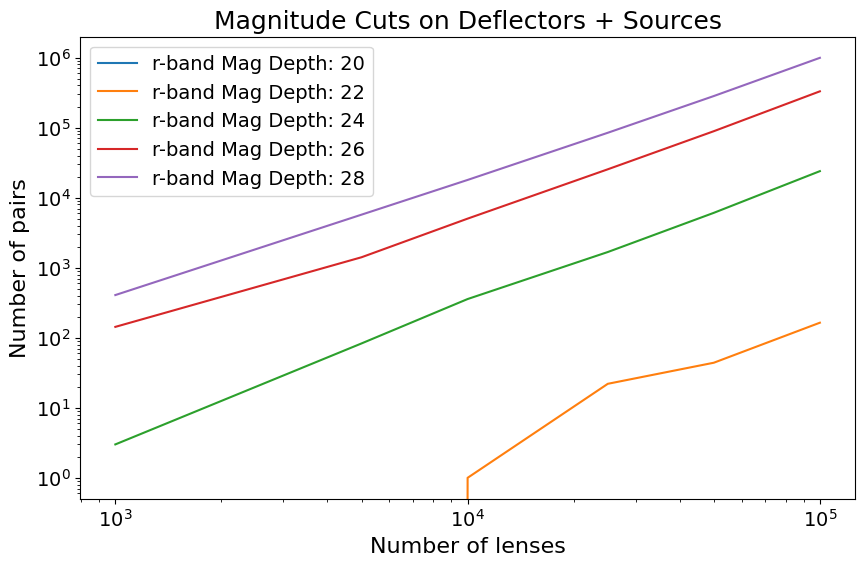

In [11]:
plt.figure(figsize=(10, 6))
for mag_depth, arr_num_pairs in dict_arr_num_pairs.items():
    plt.plot(arr_num_samples, arr_num_pairs, label=f'r-band Mag Depth: {mag_depth}')

plt.xlabel("Number of lenses", fontsize=16)
plt.ylabel("Number of pairs", fontsize=16)
plt.title("Magnitude Cuts on Deflectors + Sources", fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=14)
# plt.xlim(0, 10)
# plt.ylim(0, 0.01)

In [12]:
def estimate_plane_scatter(x_data, y_data, a, b, c, a_err, b_err, c_err):
    # 1. Calculate the predicted z-values on the plane for each (x, y) point
    z_predicted = a * x_data + b * y_data + c

    z_data = (np.random.normal(a, a_err, len(x_data)) * x_data +
              np.random.normal(b, b_err, len(y_data)) * y_data +
              np.random.normal(c, c_err, len(x_data)))

    # 2. Calculate the residuals (the vertical distance from each point to the plane)
    residuals = z_data - z_predicted

    # 3. Calculate the scatter, which is the standard deviation of the residuals
    scatter = np.std(residuals)

    return scatter, residuals

scatter, residuals = estimate_plane_scatter(
    np.log10(fake_data_org["R_e_kpc"]),
    np.log10(fake_data_org["Sigma_half_Msun/pc2"]),
    a = 1.52,
    b = -1.17,
    c = 0.45,
    a_err = 0.17,
    b_err = 0.06,
    c_err = 0.02
)
print(f"Scatter of the plane: {scatter:.2f}")

Scatter of the plane: 0.25


### Predict Number of Pairs from LSST and 4MOST

In [2]:
# load the GGL data tables with different sky areas of lenses bu galaxy population is on 10 deg^2
sky_area = "50.0v2"
GGL_data_table = Table.read(f"../data/GGL_{sky_area}_SQDEG_RED_DEFLECTOR_BLUE_SOURCE.fits", format='fits')
GGL_data_table

lens_id,z_D,z_S,theta_E,sigma_v_D,stellar_mass_D,mag_S_i,mag_S_r,mag_S_g,mag_S_z,mag_S_y,mag_D_i,mag_D_r,mag_D_g,mag_D_z,mag_D_y,size_D,e1_mass_D,e2_mass_D,e_mass_D,gamma_pl,R_e_kpc,Sigma_half_Msun/pc2,surf_bri_mag/arcsec2
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64
0,1.1395730540197462,2.721757883923871,0.6383209474735921,234.52827079090258,408649665972.69635,25.933963738373834,26.127290551620234,26.254675998006924,25.877372770610663,25.77967242684352,22.98925557393261,24.057250718125182,25.178428704908463,22.13937039113474,21.469667400192904,0.5236284022464591,-0.2185177432823041,0.0403576488557333,0.22221328481968317,2,4.30707590221643,6033.914441400326,26.23568913352215
1,1.1676192009673254,2.838231941243875,0.5428598143754139,215.84729996869848,324309245490.47504,24.22762289989987,24.307252461915994,24.330966194829777,24.19614120355442,24.25840995562706,23.4402925996813,24.481996698219838,25.35590571629431,22.647451548717875,21.931126586377424,0.2833098895986966,0.01249637671998382,-0.11601750873715334,0.11668856741216427,2,2.339785570397245,9636.754519164577,25.086016539203026
2,0.8496635018062778,3.3535717429740073,0.641000768077548,198.8149905902349,252718868917.48575,25.559769535693853,25.692328159661358,26.0026527226674,25.435595481739007,25.34701222772341,21.96306329205506,22.827566278001065,23.54640956678392,21.2303460229086,20.962437814004915,0.23774477841756192,0.0316484729535937,0.16867423476209303,0.17161766608619294,2,1.820585794159507,9782.545548619119,22.86143073655398
3,1.5030247928909466,2.1037429248665225,0.5111993143704567,314.13299407421005,883777743495.4609,26.510924542753955,26.70858277146902,27.1583892110041,26.131180343134147,25.81278128068294,23.77862974498593,25.346268769963384,26.00807169213301,22.905058039418602,22.357811050847626,1.4659095665465913,-0.009356050373493305,-0.025632148189255435,0.027286309742933265,2,12.406290085901004,3755.908492949182,29.310824741747
4,0.09931798255962809,2.1700020122674757,0.8909096122755212,182.91937545558415,192914100798.88678,26.068800062516363,26.18260302373776,26.453438870162888,25.85431274554333,25.597538901622872,15.682406808159396,16.184348056972592,17.024734167739563,15.371562734687448,15.1519986272104,1.8882089102964354,-0.03149400430312179,0.020689174501004406,0.03768174954242524,2,3.4613724155333387,993.0878825186128,20.86717108100093
5,0.5288078808555957,4.343158907234654,1.8475198758908336,295.8237930636839,760108618473.295,26.489822086076952,26.713722342261637,27.968750435273822,26.51430656934446,26.36029223477607,18.820681063983304,19.673589738103377,20.940708005983755,18.453013637031862,18.219862227367084,1.3974704615046138,-0.037506289136146086,0.029683186537268865,0.04783109122496046,2,8.783981475448723,4329.28295528526,24.12990678858026
6,1.4559015868937206,3.8947692755843875,0.6865247003713678,244.97777562316497,462966940487.00793,26.6810933315858,26.722212903637512,27.36112014871479,26.47404290286856,26.398807903193074,24.046814542508628,25.29251052208788,25.617233245782813,23.347386960561984,22.7428989776878,0.3386182857665169,-0.03450844210644334,-0.04499833975555973,0.056706993901727315,2,2.862031469438829,11700.201951750312,25.745941106562977
7,0.2806689195320025,1.7410928677555793,0.702790233640981,178.45741656564877,176660221028.014,26.85810971732381,27.019893227146323,27.191141500680875,26.537720058873933,26.28112734684412,18.536060330766365,19.020192408396266,20.210660912850745,18.275044840954653,18.081439214360305,0.5836787330604735,-0.10351118102632655,-0.293874446056699,0.31157142783412706,2,2.481363853666704,2908.161559314505,21.745803937276175
8,0.7706303273274793,4.211551756362357,0.9218938814173087,225.27783876034175,365843003536.67883,26.207415223007033,26.463795844134502,27.56823350434354,26.10852487865217,25.982309600016222,21.08702338199977,22.261540879019485,23.52052383691099,20

In [3]:
data = generate_fake_catalog(
    source_table=GGL_data_table,
    num_samples=int(len(GGL_data_table)*20000/50),  # Scale to 20000 deg^2 from 50 deg^2
)

# point source depths: g < 26.0, r < 25.7, i < 25.0, z < 24.3, y < 23.1
# extended source depths are 1 mag shallower: g < 25.0, r < 24.7, i < 24.0, z < 23.3, y < 22.1

lsst_1_yr_coadd_mag_depth_mask = ((data['mag_D_g'] < 25.0) & (data['mag_S_g'] < 25.0) &
                        (data['mag_D_r'] < 24.7) & (data['mag_S_r'] < 24.7) &
                        (data['mag_D_i'] < 24.0) & (data['mag_S_i'] < 24.0) &
                        (data['mag_D_z'] < 23.3) & (data['mag_S_z'] < 23.3) &
                        (data['mag_D_y'] < 22.1) & (data['mag_S_y'] < 22.1)
                        # (data['z_S'] < 1.5) # 4MOST limit
)

# point source depths: g < 27.4, r < 27.5, i < 26.8, z < 26.1, y < 24.9
# extended source depths are 1 mag shallower: g < 26.4, r < 26.5, i < 25.8, z < 25.1, y < 23.9

lsst_10_yr_coadd_mag_depth_mask = ((data['mag_D_g'] < 26.4) & (data['mag_S_g'] < 26.4) &
                        (data['mag_D_r'] < 26.5) & (data['mag_S_r'] < 26.5) &
                        (data['mag_D_i'] < 25.8) & (data['mag_S_i'] < 25.8) &
                        (data['mag_D_z'] < 25.1) & (data['mag_S_z'] < 25.1) &
                        (data['mag_D_y'] < 23.9) & (data['mag_S_y'] < 23.9)
                        # (data['z_S'] < 1.5) # 4MOST limit
)

lsst_4MOST_mag_depth_mask = (
                        (data['mag_D_r'] < 23) & (data['mag_S_r'] < 23) &
                        (data['z_S'] < 1.5) # 4MOST limit
)

print("Y1 # lenses:", np.sum(lsst_1_yr_coadd_mag_depth_mask))
print("Y10 # lenses:", np.sum(lsst_10_yr_coadd_mag_depth_mask))
print("4MOST # lenses:", np.sum(lsst_4MOST_mag_depth_mask))

# num of pairs


print("4MOST # pairs:", run_pairing_simulation_from_data(
    data=data[lsst_4MOST_mag_depth_mask],
    mag_limit=23,
    threshold_rel_delta_z=0.01,
    verbose=False,
    is_source_cut=True
))

Y1 # lenses: 10304
Y10 # lenses: 142542
4MOST # lenses: 5841
4MOST # pairs: 417355


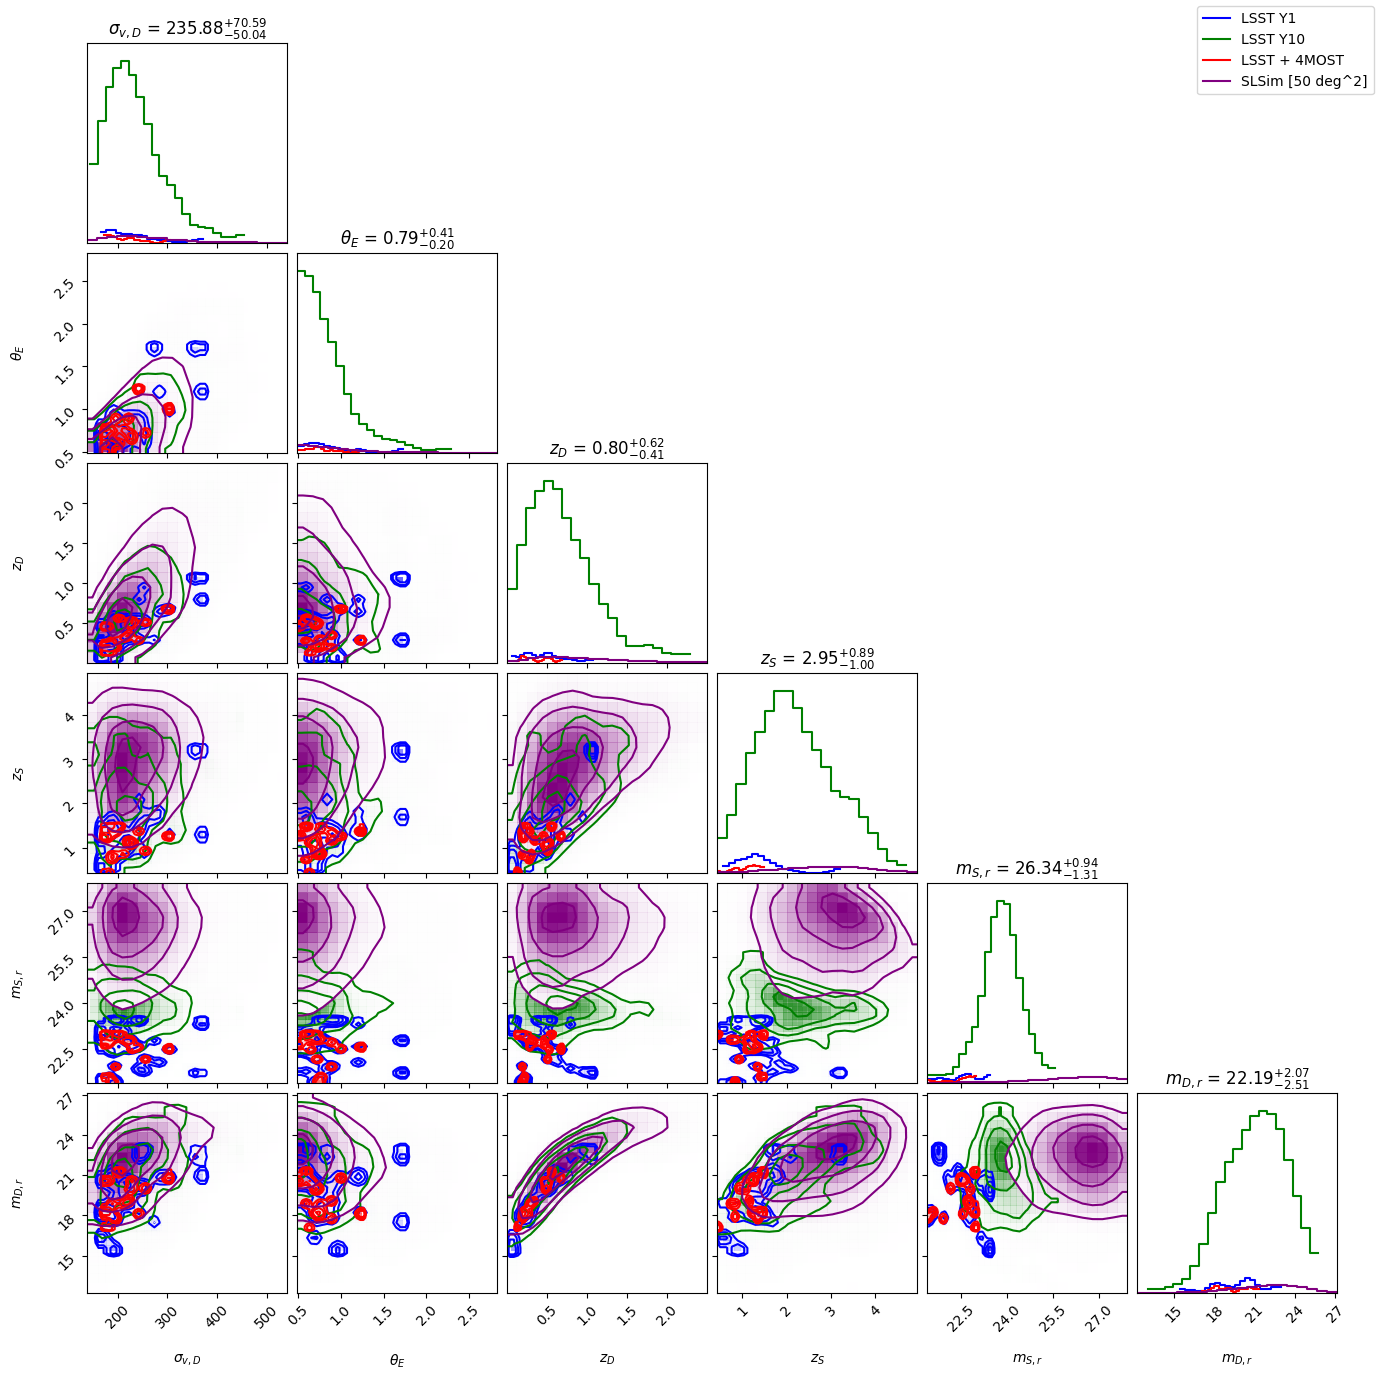

In [4]:
# plot all three samples
keys = [
    'sigma_v_D',
    'theta_E',
    'z_D',
    'z_S',
    'mag_S_r',
    'mag_D_r',
    # 'e_mass_D',
]

latex_keys = [
    r"$\sigma_{v,D}$",
    r"$\theta_{E}$",
    r"$z_{D}$",
    r"$z_{S}$",
    r"$m_{S,r}$",
    r"$m_{D,r}$",
    # r"$\varepsilon_{D}$",
]

corner_data_lsst_1yr = data[lsst_1_yr_coadd_mag_depth_mask][keys]
corner_data_lsst_1yr = np.array([corner_data_lsst_1yr[key] for key in keys]).T

corner_data_lsst_10yr = data[lsst_10_yr_coadd_mag_depth_mask][keys]
corner_data_lsst_10yr = np.array([corner_data_lsst_10yr[key] for key in keys]).T

corner_data_4MOST = data[lsst_4MOST_mag_depth_mask][keys]
corner_data_4MOST = np.array([corner_data_4MOST[key] for key in keys]).T

fig_corner = corner.corner(
    corner_data_lsst_1yr,
    labels=latex_keys,
    show_titles=True,
    smooth=True,
    smooth1d=True,
    plot_datapoints=False,
    color='blue',
    # fig=fig_corner,
);

corner.corner(
    corner_data_lsst_10yr,
    labels=latex_keys,
    show_titles=True,
    smooth=True,
    smooth1d=True,
    plot_datapoints=False,
    color='green',
    fig=fig_corner,
);

corner.corner(
    corner_data_4MOST,
    labels=latex_keys,
    show_titles=True,
    smooth=True,
    smooth1d=True,
    plot_datapoints=False,
    color='red',
    fig=fig_corner,
);

corner_data_slsim = np.array([
    GGL_data_table[key] for key in keys
]).T

corner.corner(
    corner_data_slsim,
    labels=latex_keys,
    show_titles=True,
    smooth=True,
    smooth1d=True,
    plot_datapoints=False,
    color='purple',
    fig=fig_corner,
);

fig_corner.legend(['LSST Y1', 'LSST Y10', 'LSST + 4MOST', 'SLSim [50 deg^2]'])

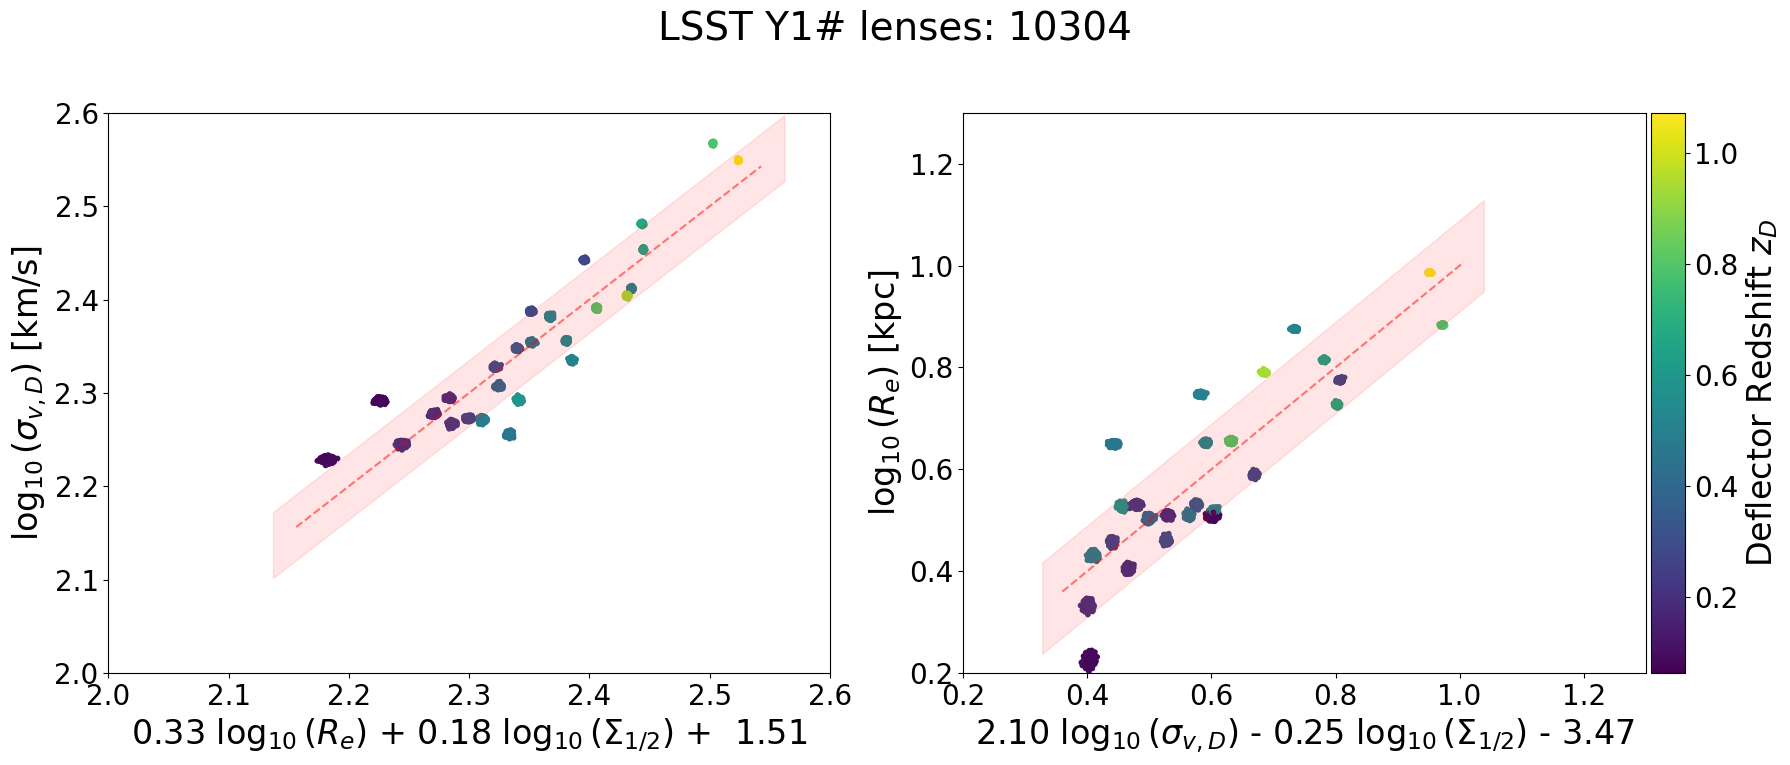

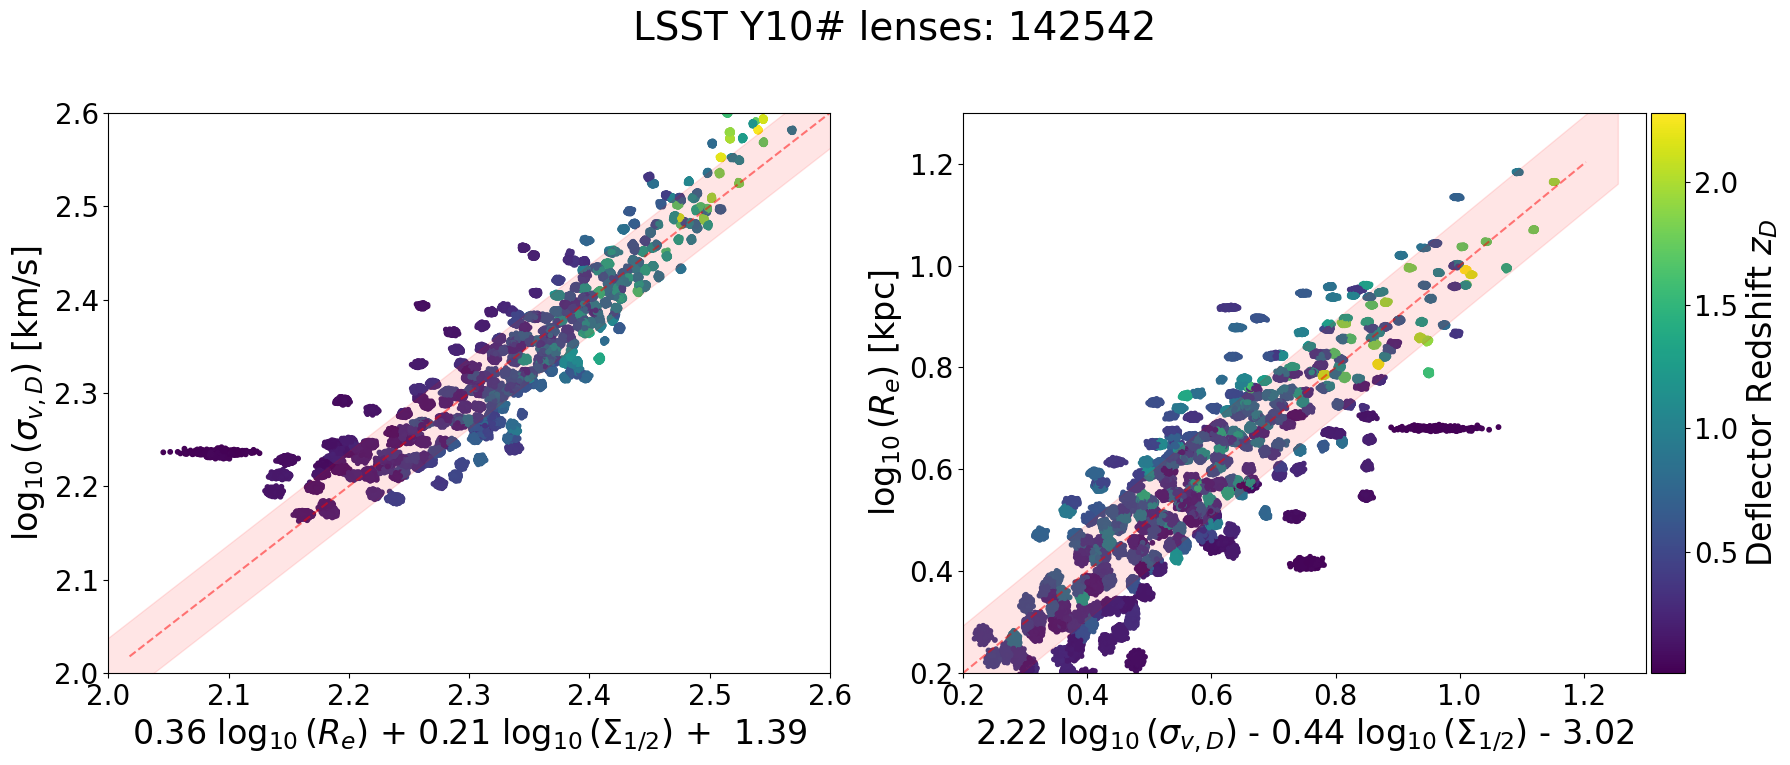

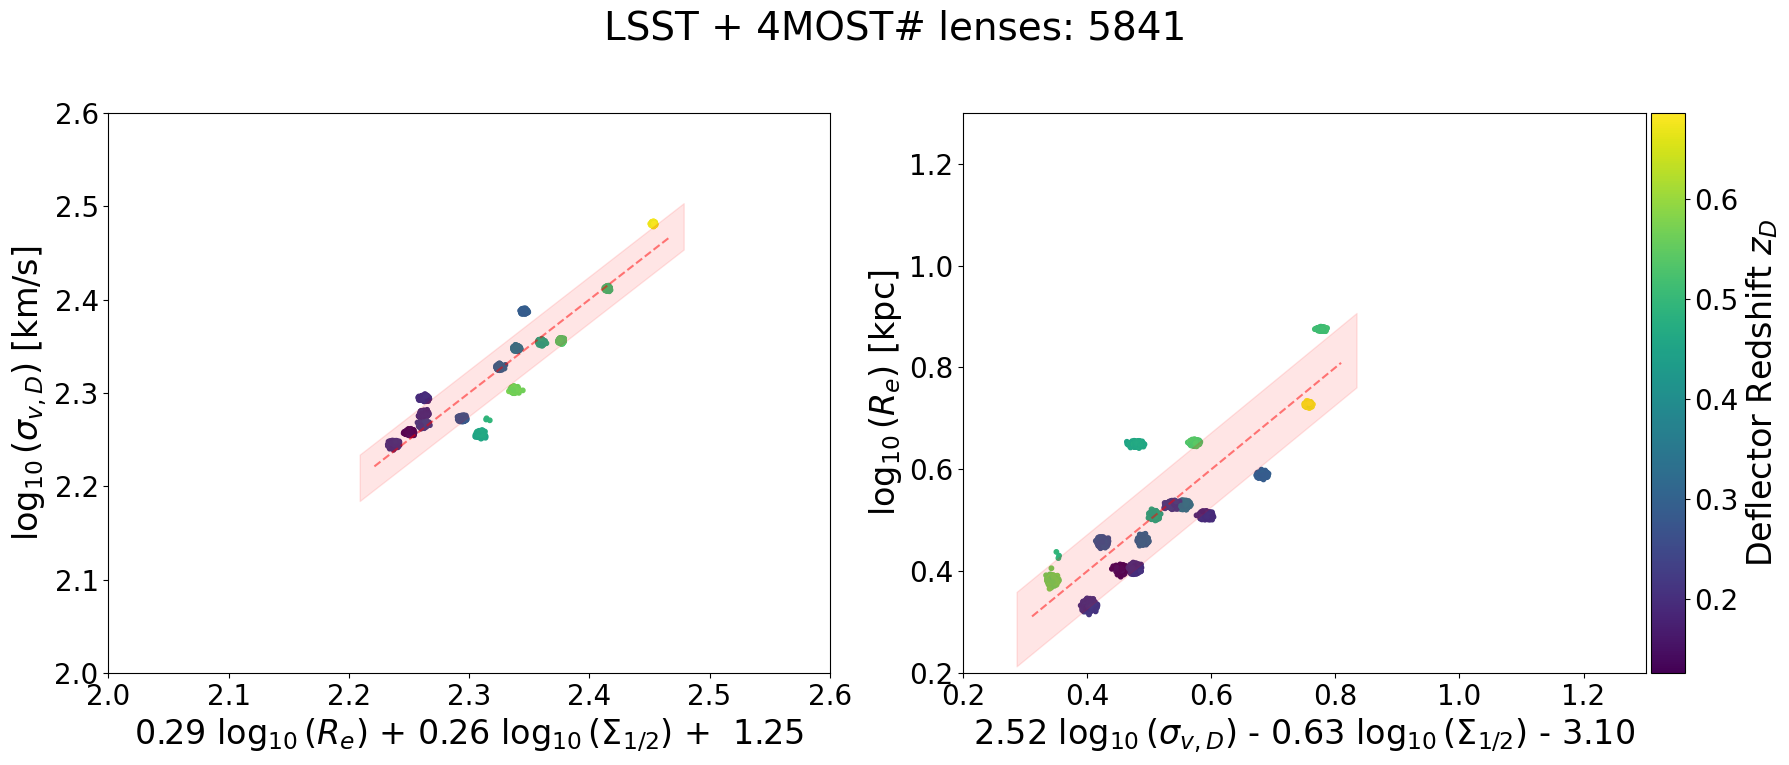

In [5]:
# MFP for the original data and the fake data

title_list = [
    "LSST Y1" + f"# lenses: {np.sum(lsst_1_yr_coadd_mag_depth_mask)}",
    "LSST Y10" + f"# lenses: {np.sum(lsst_10_yr_coadd_mag_depth_mask)}",
    "LSST + 4MOST" + f"# lenses: {np.sum(lsst_4MOST_mag_depth_mask)}"
]
i = 0
for data_table in [data[lsst_1_yr_coadd_mag_depth_mask], data[lsst_10_yr_coadd_mag_depth_mask], data[lsst_4MOST_mag_depth_mask]]:
    # fit the MFP
    coeffs_MFP = fit_plane(
        np.log10(data_table["R_e_kpc"]),
        np.log10(data_table["Sigma_half_Msun/pc2"]),
        np.log10(data_table["sigma_v_D"])
    )

    # find the scatter
    scatter_MFP = find_scatter(
        np.log10(data_table["R_e_kpc"]),
        np.log10(data_table["Sigma_half_Msun/pc2"]),
        np.log10(data_table["sigma_v_D"]),
        coeffs_MFP,
        return_fit=False
    )

    # fit the alt MFP
    coeffs_MFP_alt = fit_plane(
        np.log10(data_table["sigma_v_D"]),
        np.log10(data_table["Sigma_half_Msun/pc2"]),
        np.log10(data_table["R_e_kpc"]),
    )

    scatter_MFP_alt = find_scatter(
        np.log10(data_table["sigma_v_D"]),
        np.log10(data_table["Sigma_half_Msun/pc2"]),
        np.log10(data_table["R_e_kpc"]),
        coeffs_MFP_alt,
        return_fit=False
    )

    # side-by-side plot of the two fundamental planes
    fig, axs = plt.subplots(1, 2, figsize=(18, 8))

    # sigma_v fundamental plane
    axs[0].scatter(
        coeffs_MFP[0] * np.log10(data_table["R_e_kpc"]) + 
        coeffs_MFP[1] * np.log10(data_table["Sigma_half_Msun/pc2"]) + 
        coeffs_MFP[2],
        np.log10(data_table["sigma_v_D"]),
        c=data_table["z_D"], s=10, label='SLSim MFP', 
        cmap='viridis'
    )
    axs[0].set_xlabel(f'{coeffs_MFP[0]:.2f} ' + r'$\log_{10}(R_e)$ + ' + f'{coeffs_MFP[1]:.2f} ' + r'$\log_{10}(\Sigma_{1/2})$ + ' + f' {coeffs_MFP[2]:.2f}')
    axs[0].set_ylabel(r'$\log_{10}(\sigma_{v, D})$ [km/s]')
    # axs[0].set_title('SLSim Mass Fundamental Plane', fontsize=16)

    # Plot the fitted plane with a faded scatter
    # y = x
    axs[0].plot([axs[0].get_xlim()[0], axs[0].get_xlim()[1]],
                [axs[0].get_xlim()[0], axs[0].get_xlim()[1]],
                color='red', linestyle='--', alpha=0.5, label='y = x')
    # faded region for the scatter
    x_faded = np.linspace(axs[0].get_xlim()[0], axs[0].get_xlim()[1], 100)
    y_faded = x_faded
    axs[0].fill_between(x_faded, y_faded - np.std(scatter_MFP),
                        y_faded + np.std(scatter_MFP), color='red', alpha=0.1)

    # R_e fundamental plane
    scatter_plot = axs[1].scatter(
        coeffs_MFP_alt[0] * np.log10(data_table["sigma_v_D"]) + 
        coeffs_MFP_alt[1] * np.log10(data_table["Sigma_half_Msun/pc2"]) + 
        coeffs_MFP_alt[2],
        np.log10(data_table["R_e_kpc"]),
        c=data_table["z_D"], s=10, label='SLSim MFP', 
        cmap='viridis'
    )
    axs[1].set_xlabel(f'{coeffs_MFP_alt[0]:.2f} ' + r'$\log_{10}(\sigma_{v, D})$ ' + f'{'+' if coeffs_MFP_alt[1] > 0 else '-'} {np.abs(coeffs_MFP_alt[1]):.2f} ' + r'$\log_{10}(\Sigma_{1/2})$ ' + f'{'+' if coeffs_MFP_alt[2] > 0 else '-'} {np.abs(coeffs_MFP_alt[2]):.2f}')
    axs[1].set_ylabel(r'$\log_{10}(R_e)$ [kpc]')
    # axs[1].set_title('SLSim Mass Fundamental Plane', fontsize=16)
    # Plot the fitted plane with a faded scatter
    # y = x
    axs[1].plot([axs[1].get_xlim()[0], axs[1].get_xlim()[1]],
                [axs[1].get_xlim()[0], axs[1].get_xlim()[1]],
                color='red', linestyle='--', alpha=0.5, label='y = x')
    # faded region for the scatter
    x_faded = np.linspace(axs[1].get_xlim()[0], axs[1].get_xlim()[1], 100)
    y_faded = x_faded
    axs[1].fill_between(x_faded, y_faded - np.std(scatter_MFP_alt),
                        y_faded + np.std(scatter_MFP_alt), color='red', alpha=0.1)

    # common colorbar
    divider = make_axes_locatable(axs[1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(scatter_plot, cax=cax)
    cbar.set_label('Deflector Redshift $z_D$', fontsize=14)


    # increase the font size of the labels and title
    for ax in axs:
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.set_xlabel(ax.get_xlabel(), fontsize=24)
        ax.set_ylabel(ax.get_ylabel(), fontsize=24)
        ax.set_title(ax.get_title(), fontsize=24)
        # ax.legend(fontsize=14)

    # cbar label size
    cbar.ax.set_ylabel(cbar.ax.get_ylabel(), fontsize=24)

    # cbar tick labels
    cbar.ax.tick_params(labelsize=20)

    axs[0].set_xlim(2, 2.6)
    axs[0].set_ylim(2, 2.6)
    axs[1].set_xlim(0.2, 1.3)
    axs[1].set_ylim(0.2, 1.3)

    fig.suptitle(title_list[i], fontsize=28)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    i += 1

# save the figure
# fig.savefig(f"../figures/slsim_MFP.pdf", bbox_inches='tight', dpi=300)